# Reshape 3D fields
to 2D nodes x depth

## Setup

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd 

import sys
sys.path.append("../")

import pyfesom as pf
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
from matplotlib import cm 
from netCDF4 import Dataset

import glob

import cmocean as cmo
import cftime

from IPython import display
from tqdm import tqdm

sys.path.append("/albedo/home/quraus001/FESOM-FS-subduction/functions/")
import FESOM_processing as fprc
import FESOM_plotting as fplt

/albedo/home/quraus001/pyfesom/pyfesom/climatology.py:21: UserWarning: The seawater library is deprecated! Please use gsw instead.
  import seawater as sw


In [3]:
meshpath = "/albedo/home/quraus001/Arc08_sub/"
datapath = "/albedo/work/user/cwekerle/Arc08_sub/"
plotpath = "/albedo/home/quraus001/FESOM-FS-subduction/plots/"

In [4]:
mesh   = pf.load_mesh(meshpath)
ds_oce = fprc.load_FESOM_data_with_grid(meshpath, datapath + "Arc40.2002.oce.mean.sub.nc", vars="oce")

/albedo/home/quraus001/Arc08_sub/pickle_mesh_py3
3
The usepickle == True)
The pickle file for python 3 exists.
The mesh will be loaded from /albedo/home/quraus001/Arc08_sub/pickle_mesh_py3


## Call Reshape function

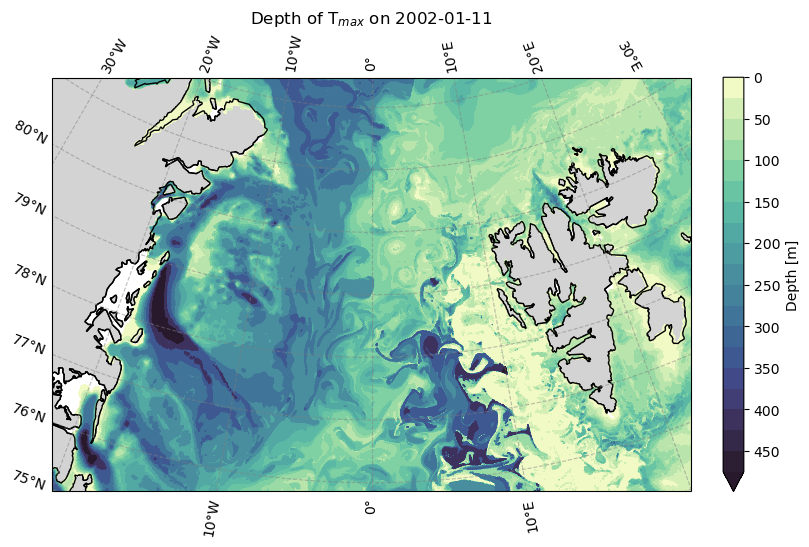

In [14]:
t = 10
temp = fprc.reshape_3d_nodes(ds_oce, "temp", time_idx=t)
#max_temp = np.nanmax(temp, axis=1)
max_temp_idx = np.nanargmax(temp, axis=1)
max_temp_depth = np.take_along_axis(ds_oce.depth_levels.values, max_temp_idx, axis=0).squeeze()
max_temp_depth = max_temp_depth*-1

formatted_date = ds_oce.time[t].values.item().strftime("%Y-%m-%d")
title="Depth of T$_{max}$ on " + formatted_date
# Plotting
fplt.plot_polar_contourf(mesh, max_temp_depth, levels=np.arange(0,500, 25), cmap=cmo.cm.deep, extend="max", flip_cbar=True, label="Depth [m]", title=title)


In [62]:
for i in tqdm(range(10)):
    # --- Get the dimensions ---
    num_nodes_2d = ds_oce['nodes_2d'].size
    num_depth_levels = ds_oce['depth_levels'].size
    # --- Initialize the reshaped temperature array ---
    temp_reshaped_vectorized_2 = np.full((num_nodes_2d, num_depth_levels), np.nan)
    
    for i, depth in enumerate(ds_oce.depth_levels.values[:-2]):
        data, elements = pf.get_data(ds_oce.temp.values[0,:], mesh, verbose=False, depth=-depth)
        temp_reshaped_vectorized_2[:,i] = data
    
temp_reshaped_vectorized_2.shape, np.nanmean(temp_reshaped_vectorized_2), np.nanmax(temp_reshaped_vectorized_2)

100%|██████████| 10/10 [00:50<00:00,  5.05s/it]


((570732, 47), np.float64(0.5846456352105577), np.float64(8.013864517211914))

In [63]:
for i in tqdm(range(10)):
    # --- Get the aux3d mapping ---
    aux3d_mapping = ds_oce['aux3d'].astype(int).values
    
    # --- Get the original temperature data for the first time step ---
    if 'temp' not in ds_oce:
        print("Error: 'temp' variable not found in ds_oce.")
        exit()
    temp_original_t0 = ds_oce['temp'].isel(time=0)
    
    # Convert known missing values (-999, large placeholders) to NaN
    temp_original_t0 = temp_original_t0.where(
        (temp_original_t0 != -999) & (temp_original_t0 < 1e10), np.nan)
    
    # --- Get the dimensions ---
    num_nodes_2d = ds_oce['nodes_2d'].size
    num_depth_levels = ds_oce['depth_levels'].size
    
    # --- Initialize the reshaped temperature array ---
    temp_reshaped_vectorized = np.full((num_nodes_2d, num_depth_levels), np.nan)
    
    # --- Find the valid 3D indices for all nodes at once ---
    valid_mask = (aux3d_mapping != -999) & (aux3d_mapping >= 0)
    
    valid_aux3d_indices_flat = aux3d_mapping[valid_mask]
    
    # --- Get the corresponding (i, j) indices for the reshaped array ---
    row_indices_2d, col_indices_depth = np.where(valid_mask)
    
    # Debug: Check if valid indices are within the expected range
    if valid_aux3d_indices_flat.size > 0:
        #print("Max index in valid_aux3d_indices_flat:", np.max(valid_aux3d_indices_flat))
        #print("Size of nodes_3d in temp_original_t0:", temp_original_t0.sizes['nodes_3d'])
        if np.max(valid_aux3d_indices_flat) >= temp_original_t0.sizes['nodes_3d']:
            print("WARNING: Some indices in valid_aux3d_indices_flat are out of bounds!")
    
    # --- Perform the vectorized indexing ---
    try:
        # Get the temperature values for all valid 3D nodes at once
        original_temp_values = temp_original_t0.isel(nodes_3d=valid_aux3d_indices_flat).values
    
        # Assign these values to the correct positions in the reshaped array
        temp_reshaped_vectorized[row_indices_2d, col_indices_depth] = np.where(
            np.isnan(original_temp_values), np.nan, original_temp_values)
    
    except IndexError as e:
        print(f"IndexError during vectorized indexing: {e}")
        print("Shape of valid_aux3d_indices_flat:", valid_aux3d_indices_flat.shape)
        print("Max index in valid_aux3d_indices_flat:", np.max(valid_aux3d_indices_flat) if valid_aux3d_indices_flat.size > 0 else "empty")
        raise e
    
temp_reshaped_vectorized.shape, np.nanmean(temp_reshaped_vectorized), np.nanmax(temp_reshaped_vectorized)

100%|██████████| 10/10 [00:04<00:00,  2.28it/s]


((570732, 47), np.float64(0.5846456352105577), np.float64(8.013864517211914))